In [19]:
import torch
import os
import matplotlib.pyplot as plt
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
"""
A scratch for PINN solving the following PDE 
u_xx - u_yyyy = (2-x^2)*exp(-y)

"""

'\nA scratch for PINN solving the following PDE \nu_xx - u_yyyy = (2-x^2)*exp(-y)\n\n'

In [3]:
def interior(n=1000):
    x = torch.rand(n,1)
    y = torch.rand(n,1)
    cond = (2 - x**2)*torch.exp(-y)
    return x.requires_grad_(True), y.requires_grad_(True), cond

In [4]:
def down_yy(n=100):
    x = torch.rand(n,1)
    y = torch.zeros_like(x)
    cond = x**2
    return x.requires_grad_(True), y.requires_grad_(True), cond

In [5]:
def up_yy(n=100):
    x = torch.rand(n,1)
    y = torch.ones_like(x)
    cond = x**2/torch.e
    return x.requires_grad_(True), y.requires_grad_(True), cond

In [6]:
def down(n=100):
    x = torch.rand(n,1)
    y = torch.zeros_like(x)
    cond = x**2
    return x.requires_grad_(True), y.requires_grad_(True), cond
    
def up(n=100):
    x = torch.rand(n,1)
    y = torch.ones_like(x)
    cond = x**2/torch.e
    return x.requires_grad_(True), y.requires_grad_(True), cond    

In [7]:
def left(n=100):
    y = torch.randn(n,1)
    x = torch.zeros_like(y)
    cond = torch.zeros_like(x)
    return x.requires_grad_(True), y.requires_grad_(True), cond 


def right(n=100):
    y = torch.randn(n,1)
    x = torch.ones_like(y)
    cond = torch.exp(-y)
    return x.requires_grad_(True), y.requires_grad_(True), cond     

In [8]:
class MLP (torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(2, 32),
            torch.nn.Tanh(), 
            torch.nn.Linear(32, 32),
            torch.nn.Tanh(), 
            torch.nn.Linear(32, 32),
            torch.nn.Tanh(), 
            torch.nn.Linear(32, 32),
            torch.nn.Tanh(), 
            torch.nn.Linear(32, 1)
        )
        
    def forward(self, x):
        return self.net(x)

In [9]:
loss = torch.nn.MSELoss()

In [13]:
def gradients(u, x, order = 1): 
    if order == 1:
        return torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), 
                                  create_graph=True,
                                  only_inputs=True,)[0]
    return gradients(gradients(u,x), x, order = order - 1)

In [14]:
def l_interior(u):
    x, y, cond = interior()
    uxy = u(torch.cat([x, y], dim=1))
    return loss(gradients(uxy, x, 2) - gradients(uxy, y, 4), cond)


def l_down_yy(u):
    x, y, cond = down_yy()
    uxy = u(torch.cat([x, y], dim=1))
    return loss(gradients(uxy, y, 2), cond)


def l_up_yy(u):
    x, y, cond = up_yy()
    uxy = u(torch.cat([x, y], dim=1))
    return loss(gradients(uxy, y, 2), cond)


def l_down(u):
    x, y, cond = down()
    uxy = u(torch.cat([x, y], dim=1))
    return loss(uxy, cond)


def l_up(u):
    x, y, cond = up()
    uxy = u(torch.cat([x, y], dim=1))
    return loss(uxy, cond)


def l_left(u):
    x, y, cond = left()
    uxy = u(torch.cat([x, y], dim=1))
    return loss(uxy, cond)


def l_right(u):
    x, y, cond = right()
    uxy = u(torch.cat([x, y], dim=1))
    return loss(uxy, cond)

In [15]:
u = MLP()
opt = torch.optim.Adam(params=u.parameters())
for i in range(1000):
    opt.zero_grad()
    l = l_interior(u) \
        + l_up_yy(u) \
        + l_down_yy(u) \
        + l_up(u) \
        + l_down(u) \
        + l_left(u) \
        + l_right(u)
    l.backward()
    opt.step()

In [20]:
# Inference
xc = torch.linspace(0, 1, 100)
xx, yy = torch.meshgrid(xc, xc)
xx = xx.reshape(-1, 1)
yy = yy.reshape(-1, 1)
xy = torch.cat([xx, yy], dim=1)
u_pred = u(xy)
u_exact = xx * xx * torch.exp(-yy)
print("Max abs error is: ", float(torch.max(torch.abs(u_pred - xx * xx * torch.exp(-yy)))))

Max abs error is:  0.016688883304595947


In [21]:
u_pred = u_pred.detach().numpy()
u_exact= u_exact.detach().numpy()
pred = u_pred.reshape(100, 100)
exact = u_exact.reshape(100,100)

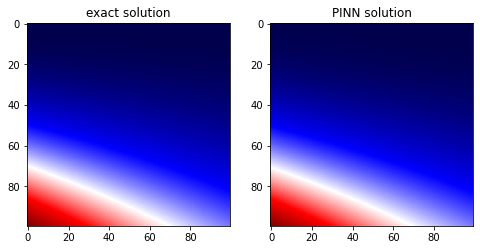

In [22]:
figure = plt.figure(figsize=(8, 8))
figure.add_subplot(1, 2, 1)
plt.title('exact solution')
plt.imshow(exact, cmap='seismic')

figure.add_subplot(1, 2, 2)
plt.title('PINN solution')
plt.imshow(pred, cmap='seismic')